
Null values in dataset:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Processed features:
['Pclass', 'Sex_male', 'Embarked_Q', 'Embarked_S', 'Age', 'Fare', 'SibSp', 'Parch']
(891, 8) (891,)


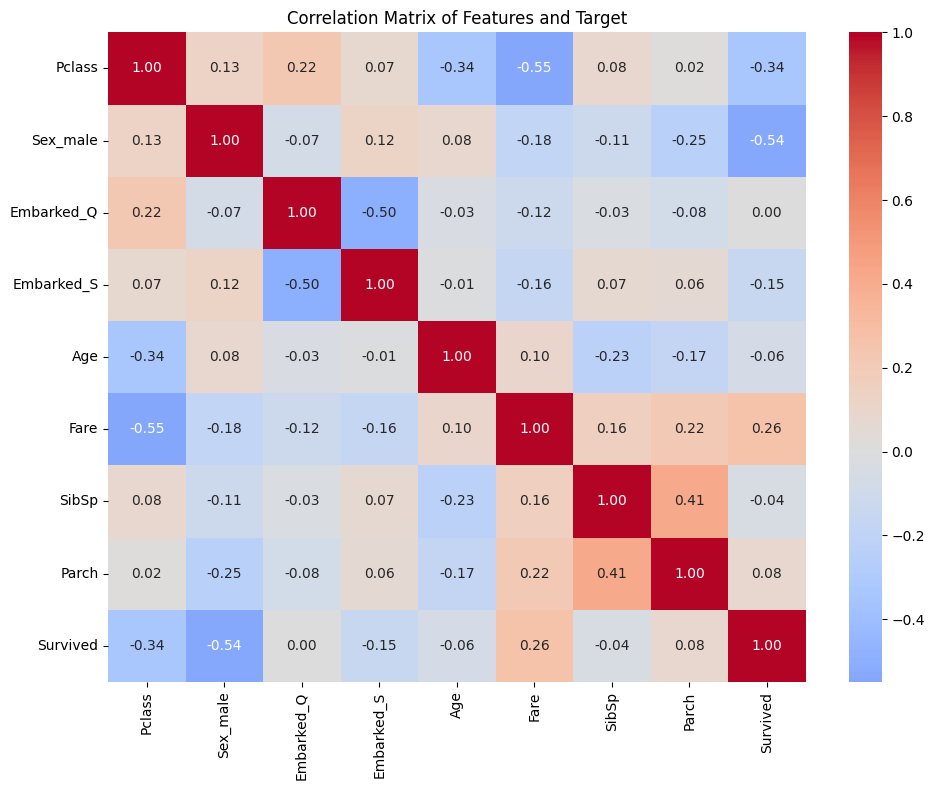


Feature correlations with Survived:
Sex_male: 0.543
Pclass: 0.338
Fare: 0.257
Embarked_S: 0.150
Parch: 0.082
Age: 0.065
SibSp: 0.035
Embarked_Q: 0.004

Selected features (correlation > 0.1):
['Sex_male', 'Pclass', 'Fare', 'Embarked_S']


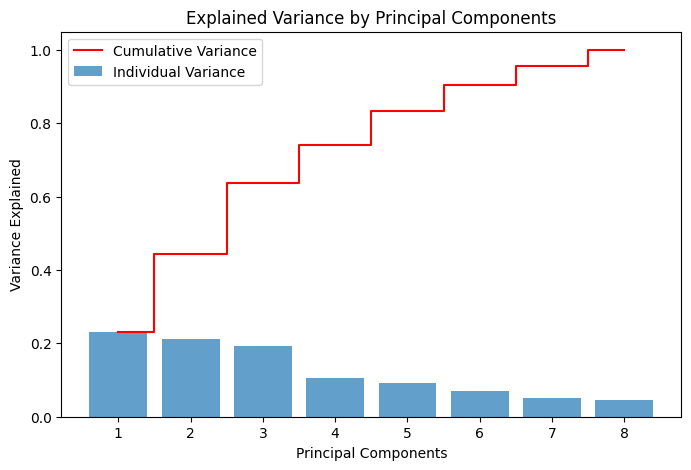

Training set shape: (712, 8), Testing set shape: (179, 8)
(712, 5)
(712,)
Iteration    0: Cost 0.6907
Iteration 2000: Cost 0.4995
Iteration 4000: Cost 0.4711
Iteration 6000: Cost 0.4587
Iteration 8000: Cost 0.4514
Iteration 10000: Cost 0.4463
Iteration 12000: Cost 0.4426
Iteration 14000: Cost 0.4398
Iteration 16000: Cost 0.4377
Iteration 18000: Cost 0.4360
Final cost after gradient descent: 0.4347


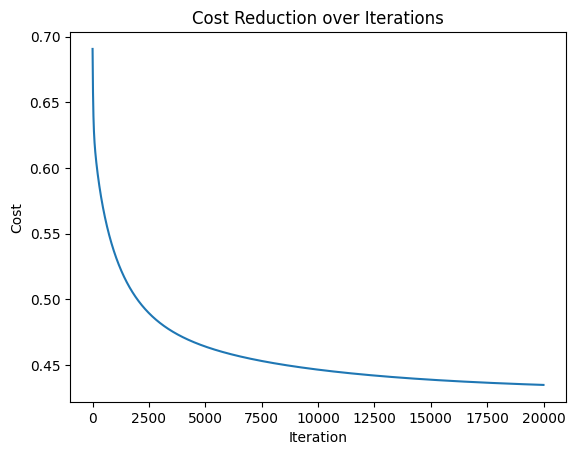

Train Accuracy: 80.617978
Train Precision: 78.455285
Train Recall: 69.424460
Train F1 Score: 73.664122
Test Accuracy: 78.212291
Test Precision: 73.584906
Test Recall: 60.937500
Test F1 Score: 66.666667


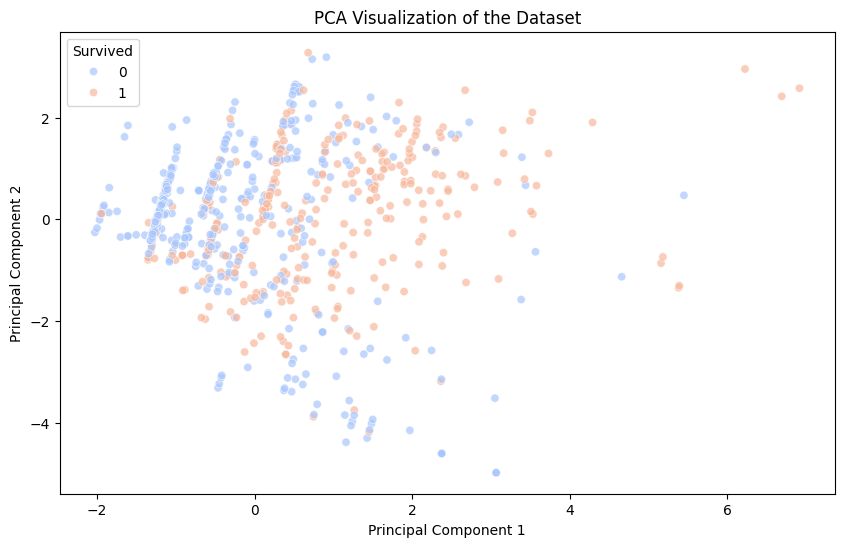

Iteration    0: Cost 0.6907
Iteration  500: Cost 0.5665
Iteration 1000: Cost 0.5339
Iteration 1500: Cost 0.5135
Iteration 2000: Cost 0.4995
Iteration 2500: Cost 0.4894
Iteration 3000: Cost 0.4818
Iteration 3500: Cost 0.4758
Iteration 4000: Cost 0.4711
Iteration 4500: Cost 0.4672
Iteration    0: Cost 0.6930
Iteration  500: Cost 0.6683
Iteration 1000: Cost 0.6662
Iteration 1500: Cost 0.6660
Iteration 2000: Cost 0.6660
Iteration 2500: Cost 0.6660
Iteration 3000: Cost 0.6660
Iteration 3500: Cost 0.6660
Iteration 4000: Cost 0.6660
Iteration 4500: Cost 0.6660
Logistic Regression Accuracy (without PCA): 78.21%
Logistic Regression Accuracy (with PCA): 64.25%
SVM Accuracy (without PCA): 79.89%
SVM Accuracy (with PCA): 64.25%


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *

def preprocess_titanic_data(df):
    """
    Preprocessing of Titanic dataset
    """
    # Create a copy to avoid modifying original data
    data = df.copy()
    
    # Check null values
    print("\nNull values in dataset:")
    print(data.isnull().sum())
    
    # Handle missing values - using recommended pandas syntax
    data.loc[:, 'Age'] = data['Age'].fillna(data['Age'].median())
    data.loc[:, 'Fare'] = data['Fare'].fillna(data['Fare'].median())
    data.loc[:, 'Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])
    
    # Extract target variable
    y = data['Survived']
    
    # Select features for processing
    features_to_encode = ['Sex', 'Embarked', 'Pclass']
    numerical_features = ['Age', 'Fare', 'SibSp', 'Parch']
    
    # Create dummy variables for categorical features
    X = pd.get_dummies(data[features_to_encode], drop_first=True)
    
    # Add standardized numerical features
    for feature in numerical_features:
        X[feature] = (data[feature] - data[feature].mean()) / data[feature].std()
    
    return X, y

def analyze_features(X, y):
    """
    Analyze feature importance using correlation matrix
    """
    # Add target to features for correlation analysis
    data_corr = X.copy()
    data_corr['Survived'] = y
    
    # Calculate and display correlation matrix
    correlation_matrix = data_corr.corr()
    
    # Create correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title('Correlation Matrix of Features and Target')
    plt.tight_layout()
    plt.show()
    
    # Get feature correlations with target
    target_correlations = abs(correlation_matrix['Survived']).sort_values(ascending=False)
    target_correlations = target_correlations.drop('Survived')
    
    print("\nFeature correlations with Survived:")
    for feature, corr in target_correlations.items():
        print(f"{feature}: {corr:.3f}")
    
    # Select features with correlation > 0.1
    selected_features = target_correlations[target_correlations > 0.1].index.tolist()
    
    print("\nSelected features (correlation > 0.1):")
    print(selected_features)
    
    return X[selected_features]

# PCA implementation
def apply_pca(X, n_components):
    # Step 1: Standardize the data
    X_std = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

    # Step 2: Calculate the covariance matrix
    covariance_matrix = np.cov(X_std.T)

    # Step 3: Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

    # Step 4: Sort eigenvalues and eigenvectors
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    # Step 5: Select top n_components eigenvectors
    principal_components = eigenvectors[:, :n_components]

    # Step 6: Transform the data
    X_pca = np.dot(X_std, principal_components)

    # Explained variance
    explained_variance = eigenvalues / sum(eigenvalues)
    cumulative_variance = np.cumsum(explained_variance)

    # Plot explained variance
    plt.figure(figsize=(8, 5))
    plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, label='Individual Variance')
    plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative Variance', color='red')
    plt.xlabel('Principal Components')
    plt.ylabel('Variance Explained')
    plt.title('Explained Variance by Principal Components')
    plt.legend()
    plt.show()

    return X_pca

# Data splitting

def split_data(X, y, test_size=0.2):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    split = int(X.shape[0] * (1 - test_size))
    train_idx, test_idx = indices[:split], indices[split:]
    return X[train_idx], X[test_idx], y.iloc[train_idx], y.iloc[test_idx]

# Load and process data
df = pd.read_csv('titanic(1).csv')

# Preprocess data
X, y = preprocess_titanic_data(df)
print("\nProcessed features:")
print(X.columns.tolist())

print(X.shape, y.shape)


# Perform feature selection
X_selected = analyze_features(X, y)

# PCA transformation
X_pca = apply_pca(X, n_components=5)

# Split data
X_train, X_test, y_train, y_test = split_data(X.values, y, test_size=0.2)
print(f"Training set shape: {X_train.shape}, Testing set shape: {X_test.shape}")
X_pca_train, X_pca_test, _, _ = split_data(X_pca, y, test_size=0.2)

print(X_pca_train.shape)
print(y_train.shape)

def sigmoid(z):
    z = np.array(z, dtype=float)  # Ensures z is a numpy array with float type
    return 1 / (1 + np.exp(-z))

def compute_cost(X, y, w, b, lambda_=0): 
    m = len(y)
    z = np.dot(X, w) + b
    f_wb = sigmoid(z)
    cost = -np.mean(y * np.log(f_wb + 1e-10) + (1 - y) * np.log(1 - f_wb + 1e-10))  # Avoid log(0)
    return cost + (lambda_ / (2 * m)) * np.sum(w ** 2)  # Regularization term

def compute_gradient(X, y, w, b, lambda_=0): 
    m, n = X.shape
    f_wb = sigmoid(np.dot(X, w) + b)
    error = f_wb - y
    
    dj_dw = (1 / m) * np.dot(X.T, error) + (lambda_ / m) * w  # Regularized gradient
    dj_db = np.mean(error)
    
    return dj_db, dj_dw

def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters, lambda_):
    # Ensure inputs are numpy arrays of type float
    X = np.array(X, dtype=float)
    y = np.array(y, dtype=float)
    w = np.array(w_in, dtype=float)
    b = float(b_in)  # Make sure b is a float

    J_history = []
    w_history = []

    for i in range(num_iters):
        # Calculate the gradient and update the parameters
        dj_db, dj_dw = gradient_function(X, y, w, b, lambda_)
        
        # Ensure gradient outputs are floats
        dj_dw = np.array(dj_dw, dtype=float)
        dj_db = float(dj_db)
        
        # Update parameters using learning rate (alpha)
        w -= alpha * dj_dw
        b -= alpha * dj_db
        
        # Save cost J at each iteration for monitoring
        cost = cost_function(X, y, w, b, lambda_)
        J_history.append(cost)

        # Print cost every 10% of iterations
        if i % max(1, num_iters // 10) == 0:
            w_history.append(w.copy())
            print(f"Iteration {i:4}: Cost {cost:.4f}")

    return w, b, J_history, w_history

# Initialize weights and bias for logistic regression
initial_w = np.zeros((X_train.shape[1],))  # Make sure it has the same number of columns as X_train
initial_b = 0.

# Set gradient descent parameters
iterations = 20000
alpha = 0.01

# Run gradient descent
w, b, J_history, _ = gradient_descent(X_train, y_train, initial_w, initial_b, compute_cost, compute_gradient, alpha, iterations, lambda_=0)

print(f"Final cost after gradient descent: {J_history[-1]:.4f}")

plt.plot(J_history)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost Reduction over Iterations")
plt.show()

def predict(X, w, b): 
    # Calculate the linear combination of inputs and weights plus bias
    z_wb = np.dot(X, w) + b
    
    # Apply the sigmoid function to get probabilities
    f_wb = sigmoid(z_wb)
    
    # Apply the threshold to get binary predictions
    p = (f_wb > 0.5).astype(int)  # Convert boolean to int (0 or 1)
    
    return p

def calculate_precision(y_true, y_pred):
    """
    Calculate precision
    """
    true_positives = np.sum((y_true == 1) & (y_pred == 1))
    false_positives = np.sum((y_true == 0) & (y_pred == 1))
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    return precision

def calculate_recall(y_true, y_pred):
    """
    Calculate recall
    """
    true_positives = np.sum((y_true == 1) & (y_pred == 1))
    false_negatives = np.sum((y_true == 1) & (y_pred == 0))
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    return recall

def calculate_f1_score(y_true, y_pred):
    """
    Calculate F1 Score
    """
    precision = calculate_precision(y_true, y_pred)
    recall = calculate_recall(y_true, y_pred)
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return f1_score

# After making predictions on the training and test sets, add these lines to calculate precision, recall, and F1 score

# Make predictions on the training set
p_train = predict(X_train, w, b)
print('Train Accuracy: %f' % (np.mean(p_train == y_train) * 100))

# Calculate metrics for the training set
train_precision = calculate_precision(y_train, p_train)
train_recall = calculate_recall(y_train, p_train)
train_f1_score = calculate_f1_score(y_train, p_train)

print('Train Precision: %f' % (train_precision * 100))
print('Train Recall: %f' % (train_recall * 100))
print('Train F1 Score: %f' % (train_f1_score * 100))

# Make predictions on the test set
p_test = (sigmoid(np.dot(X_test, w) + b) > 0.5).astype(int)
print('Test Accuracy: %f' % (np.mean(p_test == y_test) * 100))

# Calculate metrics for the test set
test_precision = calculate_precision(y_test, p_test)
test_recall = calculate_recall(y_test, p_test)
test_f1_score = calculate_f1_score(y_test, p_test)

print('Test Precision: %f' % (test_precision * 100))
print('Test Recall: %f' % (test_recall * 100))
print('Test F1 Score: %f' % (test_f1_score * 100))

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='coolwarm', alpha=0.7)
plt.title('PCA Visualization of the Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Survived')
plt.show()

# Logistic regression without PCA
w = np.zeros(X_train.shape[1])
b = 0
w, b, J_history, _ = gradient_descent(X_train, y_train, w, b, alpha=0.01, num_iters=5000, cost_function=compute_cost, gradient_function=compute_gradient,lambda_=0)
y_pred_lr = (sigmoid(np.dot(X_test, w) + b) > 0.5).astype(int)
lr_acc = np.mean(y_pred_lr == y_test) * 100

# Logistic regression with PCA
w_pca = np.zeros(X_pca_train.shape[1])
b_pca = 0
w_pca, b_pca, J_history, _ = gradient_descent(X_pca_train, y_train, w_pca, b_pca, alpha=0.01, num_iters=5000, cost_function=compute_cost, gradient_function=compute_gradient,lambda_=0)
y_pred_lr_pca = (sigmoid(np.dot(X_pca_test, w_pca) + b_pca) > 0.5).astype(int)
lr_pca_acc = np.mean(y_pred_lr_pca == y_test) * 100

# SVM without PCA
from sklearn.svm import SVC
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
svm_acc = np.mean(y_pred_svm == y_test) * 100

# SVM with PCA
svm_pca = SVC(kernel='linear')
svm_pca.fit(X_pca_train, y_train)
y_pred_svm_pca = svm_pca.predict(X_pca_test)
svm_pca_acc = np.mean(y_pred_svm_pca == y_test) * 100

# Results comparison
print(f"Logistic Regression Accuracy (without PCA): {lr_acc:.2f}%")
print(f"Logistic Regression Accuracy (with PCA): {lr_pca_acc:.2f}%")
print(f"SVM Accuracy (without PCA): {svm_acc:.2f}%")
print(f"SVM Accuracy (with PCA): {svm_pca_acc:.2f}%")